## Installation

In [1]:
if (!requireNamespace("devtools", quietly = TRUE)) install.packages("devtools")
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
devtools::install_github("GreenleafLab/ArchR", ref="master", repos = BiocManager::repositories())

library(ArchR)
ArchR::installExtraPackages()

Skipping install of 'ArchR' from a github remote, the SHA1 (ddcaae4a) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, matc

## Getting set up

In [2]:
addArchRThreads(threads = 1)
addArchRGenome("hg19")
addArchRLogging()

inputFiles <- getTutorialData("Hematopoiesis")
inputFiles

Setting default number of Parallel threads to 1.

Setting default genome to Hg19.

Setting ArchRLogging = TRUE



scATAC_BMMC_R1 
     "HemeFragments/scATAC_BMMC_R1.fragments.tsv.gz" 
                                 scATAC_CD34_BMMC_R1 
"HemeFragments/scATAC_CD34_BMMC_R1.fragments.tsv.gz" 
                                      scATAC_PBMC_R1 
     "HemeFragments/scATAC_PBMC_R1.fragments.tsv.gz"

## Creating arrow files

In [3]:
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  filterTSS = 4, #Dont set this too high because you can always increase later
  filterFrags = 1000,
  addTileMat = TRUE,
  addGeneScoreMat = TRUE
)

ArrowFiles

Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

ArchR logging to : ArchRLogs/ArchR-createArrows-32116f7fbab1-Date-2020-10-08_Time-12-56-35.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2020-10-08 12:56:35 : Batch Execution w/ safelapply!, 0 mins elapsed.

(scATAC_BMMC_R1 : 1 of 3) Determining Arrow Method to use!

Attempting to index HemeFragments/scATAC_BMMC_R1.fragments.tsv.gz as tabix..

2020-10-08 12:56:40 : (scATAC_BMMC_R1 : 1 of 3) Reading In Fragments from inputFiles (readMethod = tabix), 0.085 mins elapsed.

2020-10-08 12:56:40 : (scATAC_BMMC_R1 : 1 of 3) Tabix Bed To Temporary File, 0.086 mins elapsed.

2020-10-08 12:56:54 : (scATAC_BMMC_R1 : 1 of 3) Reading TabixFile 8 Percent, 0.323 mins elapsed.

2020-10-08 12:57:06 : (scATAC_BMMC_R1 : 1 of 3) Reading TabixFile 17 Percent, 0.51 mins elapsed.

2020-10-08 12:57:16 : (scATAC_BMMC_R1 : 1 of 3) Reading TabixFile 25 Percent, 0.686 m

2020-10-08 13:12:35 : (scATAC_PBMC_R1 : 3 of 3) CellStats : Number of Cells Pass Filter = 2454 , 15.999 mins elapsed.

2020-10-08 13:12:35 : (scATAC_PBMC_R1 : 3 of 3) CellStats : Median Frags = 3349.5 , 15.999 mins elapsed.

2020-10-08 13:12:35 : (scATAC_PBMC_R1 : 3 of 3) CellStats : Median TSS Enrichment = 19.9535 , 15.999 mins elapsed.

2020-10-08 13:12:36 : (scATAC_PBMC_R1 : 3 of 3) Adding Additional Feature Counts!, 16.022 mins elapsed.

2020-10-08 13:13:21 : (scATAC_PBMC_R1 : 3 of 3) Removing Fragments from Filtered Cells, 16.774 mins elapsed.

2020-10-08 13:13:21 : (scATAC_PBMC_R1 : 3 of 3) Creating Filtered Arrow File, 16.774 mins elapsed.

2020-10-08 13:13:38 : (scATAC_PBMC_R1 : 3 of 3) Finished Constructing Filtered Arrow File!, 17.046 mins elapsed.

2020-10-08 13:13:38 : (scATAC_PBMC_R1 : 3 of 3) Adding TileMatrix!, 17.046 mins elapsed.

2020-10-08 13:14:32 : (scATAC_PBMC_R1 : 3 of 3) Adding GeneScoreMatrix!, 17.956 mins elapsed.

2020-10-08 13:15:39 : (scATAC_PBMC_R1 : 3 of 

[1] "scATAC_BMMC_R1.arrow"      "scATAC_CD34_BMMC_R1.arrow"
[3] "scATAC_PBMC_R1.arrow"

## 1. Per-cell Quality Control
Strict quality control (QC) of scATAC-seq data is essential to remove the contribution of low-quality cells. In ArchR, we consider three characteristics of data:

1. The number of unique nuclear fragments (i.e. not mapping to mitochondrial DNA).

2. The signal-to-background ratio. Low signal-to-background ratio is often attributed to dead or dying cells which have de-chromatinzed DNA which allows for random transposition genome-wide.

3. The fragment size distribution. Due to nucleosomal periodicity, we expect to see depletion of fragments that are the length of DNA wrapped around a nucleosome (approximately 147 bp).

The first metric, **unique nuclear fragments**, is straightforward - cells with very few usable fragments will not provide enough data to make useful interpretations and should therefore be excluded.

The second metric, **signal-to-background ratio**, is calculated as the TSS enrichment score. Traditional bulk ATAC-seq analysis has used this TSS enrichment score as part of a standard workflow for determination of signal-to-background (for example, the [ENCODE](https://www.encodeproject.org/atac-seq/) project). We and others have found the TSS enrichment to be representative across the majority of cell types tested in both bulk ATAC-seq and scATAC-seq. The idea behind the TSS enrichment score metric is that ATAC-seq data is universally enriched at gene TSS regions compared to other genomic regions, due to large protein complexes that bind to promoters. By looking at per-basepair accessibility centered at these TSS regions, we see a local enrichment relative to flanking regions (1900-2000 bp distal in both directions). The ratio between the peak of this enrichment (centered at the TSS) relative to these flanking regions represents the TSS enrichment score.

Traditionally, the per-base-pair accessibility is computed for each bulk ATAC-seq sample and then this profile is used to determine the TSS enrichment score. Performing this operation on a per-cell basis in scATAC-seq is relatively slow and computationally expensive. To accurately approximate the TSS enrichment score per single cell, we count the average accessibility within a 50-bp region centered at each single-base TSS position and divide this by the average accessibility of the TSS flanking positions (+/- 1900 – 2000 bp). This approximation was highly correlated (R > 0.99) with the original method and values were extremely close in magnitude.

The third metric, **fragment size distribution**, is generally less important but always good to manually inspect. Because of the patterned way that DNA wraps around nucleosomes, we expect to see a nucleosomal periodicity in the distribution of fragment sizes in our data. These hills and valleys appear because fragments must span 0, 1, 2, etc. nucleosomes (Tn5 cannot cut DNA that is tightly wrapped around a nucleosome.

By default in ArchR, pass-filter cells are identified as those cells having a TSS enrichment score greater than 4 and more than 1000 unique nuclear fragments. **It is important to note that the actual numeric value of the TSS enrichment score depends on the set of TSSs used.** The default values in ArchR were designed for human data and it may be important to change the default thresholds when running `createArrowFiles()`.

Creation of Arrow files will create a folder in the current working directory called “QualityControl” which will contain 2 plots associated with each of your samples. The first plot shows the `log10(unique nuclear fragments)` vs TSS enrichment score and indicates the thresholds used with dotted lines. The second shows the fragment size distribution.

## 2. Doublet Inference
One major source of trouble in single-cell data is the contribution of “doublets” to the analysis. A doublet refers to a single droplet that received a single barcoded bead and more than one nucleus. This causes the reads from more than one cell to appear as a single cell that is effectively the average of the two cells. We remove these computationally and describe this doublet removal process in depth in this chapter.

### 2.1 How does doublet identification work in ArchR?

Single-cell data generated on essentially any platform is susceptible to the presence of doublets. A doublet refers to a single droplet that received a single barcoded bead and more than one nucleus. This causes the reads from more than one cell to appear as a single cell. For 10x, the percentage of total “cells” that are actually doublets is proportional to the number of cells loaded into the reaction. Even at the lower levels of doublets that result from standard kit use, more than 5% of the data may come from doublets and this exerts substantial effects on clustering. This issue becomes particularly problematic in the context of developmental/trajectory data because doublets look like a mixture between two cell types and this can be confounded with intermediate cell types or cell states.

To predict which “cells” are actually doublets, we synthesize in silico doublets from the data by mixing the reads from thousands of combinations of individual cells. We then project these synthetic doublets into the UMAP embedding and identify their nearest neighbor. By iterating this procedure thousands of times, we can identify “cells” in our data whose signal looks very similar to synthetic doublets.

![title](markdown-images/doublet-inference.png)

To develop and validate ArchR’s doublet identification, we generated scATAC-seq data from pooled mixtures of 10 genetically distinct cell lines. In scATAC-seq space, these 10 cell lines should form 10 distinct clusters but when we deliberately overload the 10x Genomics scATAC-seq reaction, targetting 25,000 cells per reaction, we end up with many doublets. We know these are doublets because we use [demuxlet](https://github.com/statgen/demuxlet) to identify droplets that contain genotypes from two different cell types.

![title](markdown-images/doublet-inference-2.png)

After we computationally remove these doublets with ArchR, the overall structure of our data changes dramatically and matches our expectation of 10 distinct cell types.

![title](markdown-images/doublet-inference-3.png)

### 2.2 Inferring scATAC-seq doublets with ArchR
By default ArchR uses the doublet parameters described in the ArchR manuscript. This is likely a good place to start but we encourage all users to inspect the pre- and post-doublet removal data to understand how doublet removal is affecting the cells. We show some of the main adjustable features below to illustrate how this can be customized to a given application.

In ArchR, doublet removal is performed in a single step using `addDoubletScores()`. This adds the infered doublet scores to each Arrow file and will take approximately 2-5 minutes per sample of the tutorial data. You can always try `?addDoubletScores` to see further documentation on parameters for doublet identification (or any ArchR function for that matter).


ArchR logging to : ArchRLogs/ArchR-addDoubletScores-321176a5e948-Date-2020-10-08_Time-13-15-39.log
If there is an issue, please report to github with logFile!

2020-10-08 13:15:39 : Batch Execution w/ safelapply!, 0 mins elapsed.

2020-10-08 13:15:39 : scATAC_BMMC_R1 (1 of 3) :  Computing Doublet Statistics, 0 mins elapsed.

scATAC_BMMC_R1 (1 of 3) : UMAP Projection R^2 = 0.98096

scATAC_BMMC_R1 (1 of 3) : UMAP Projection R^2 = 0.98096



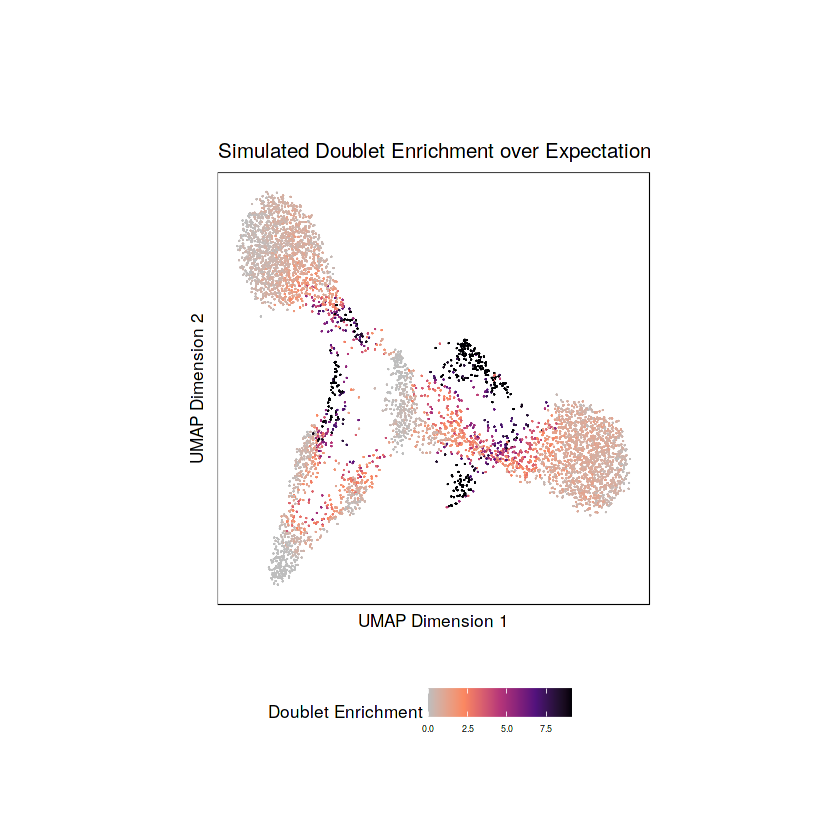

2020-10-08 13:17:25 : scATAC_CD34_BMMC_R1 (2 of 3) :  Computing Doublet Statistics, 1.752 mins elapsed.

scATAC_CD34_BMMC_R1 (2 of 3) : UMAP Projection R^2 = 0.98958

scATAC_CD34_BMMC_R1 (2 of 3) : UMAP Projection R^2 = 0.98958

2020-10-08 13:18:46 : scATAC_PBMC_R1 (3 of 3) :  Computing Doublet Statistics, 3.115 mins elapsed.

scATAC_PBMC_R1 (3 of 3) : UMAP Projection R^2 = 0.98628

scATAC_PBMC_R1 (3 of 3) : UMAP Projection R^2 = 0.98628

ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-321176a5e948-Date-2020-10-08_Time-13-15-39.log



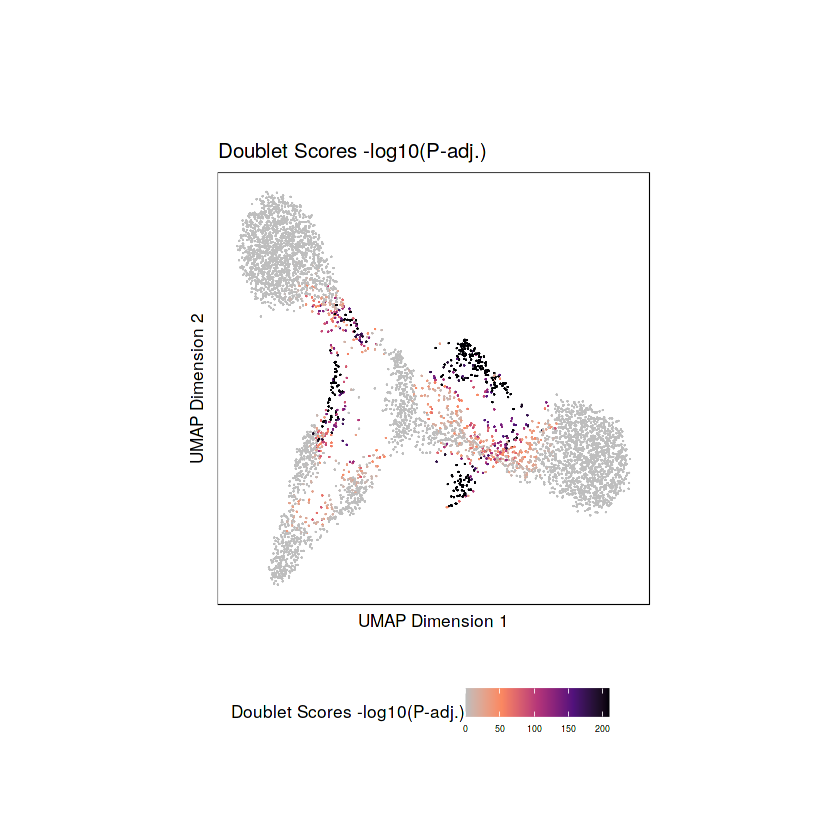

In [4]:
doubScores <- addDoubletScores(
    input = ArrowFiles,
    k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
    knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search with doublet projection.
    LSIMethod = 1
)

In the above output, ArchR reports the R2 value for the UMAP projection for each Arrow file. If these R2 values are much lower (i.e. less than 0.9), this often indicates that the cells within the Arrow file have very little heterogeneity. This makes the accuracy of doublet calling worse because the majority of doublets would be “homotypic” - or a single droplet with two very similar cells. In these cases, we recommend skipping doublet prediction. Alternatively, you can try setting `knnMethod = "LSI"` and `force = TRUE` to perform projection in the LSI subspace; however, you should manually assess the results and make sure this is performing as you would expect.

Adding doublet scores will create plots in the “QualityControl” directory. There are 3 plots associated with each of your samples in this folder:

1. **Doublet Enrichments** - These represent the enrichment of simulated doublets nearby each single cell compared to the expected if we assume a uniform distribution.

2. **Doublet Scores** - These represent the significance `(-log10(binomial adjusted p-value))` of simulated doublets nearby each single cell compared to the expected if we assume a uniform distribution. We have found this value to be less consistent than the doublet enrichments and therefore use doublet enrichments for doublet identification.

3. **Doublet Density** - This represents the density of the simulated doublet projections. This allows you to visualize where the synthetic doublets were located after projection into your 2-dimensional embedding.

## 3. Creating an ArchR Project
An `ArchRProject` allows us to group multiple Arrow files together into a single project. This `ArchRProject` is small and is stored in memory. By interacting with the `ArchRProject` we can rapidly push and pull data from the Arrow files. As such, it forms the basis of nearly all ArchR functions and analytical workflows. Moreover, `ArchRProject` objects can be saved and re-loaded at a later date, providing continuity of analyses and facilitating sharing of analytical projects across collaborators. This chapter describes how to create and interact with an `ArchRProject` object.

### 3.1 Creating an ArchR Project
First, we must create our `ArchRProject` by providing a list of Arrow files and a few other parameters. The `outputDirectory` here describes where all downstream analyses and plots will be saved. ArchR will automatically associate the previously provided `geneAnnotation` and `genomeAnnotation` with the new ArchRProject. These were stored when we ran `addArchRGenome("hg19")` in a previous chapter.

In [5]:
projHeme1 <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = "HemeTutorial",
  copyArrows = TRUE #This is recommened so that if you modify the Arrow files you have an original copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

Validating Arrows...

Getting SampleNames...

1 
2 
3 


Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 
2 
3 


Getting Cell Metadata...

1 
2 
3 


Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||    

We call this `ArchRProject` “projHeme1” because it is the first iteration of our hematopoiesis project. Throughout this walkthrough we will modify and update this `ArchRProject` and keep track of which version of the project we are using by iterating the project number (i.e. “projHeme2”).

We can examine the contents of our `ArchRProject`:

In [6]:
projHeme1


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/james/Documents/Leuven/year-two/Integrated-Bioinformatics-Project/ArchR/Archr-tutorial/HemeTutorial 
samples(3): scATAC_BMMC_R1 scATAC_CD34_BMMC_R1 scATAC_PBMC_R1
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 10661
medianTSS(1): 16.832
medianFrags(1): 3050

We can see from the above that our `ArchRProject` has been initialized with a few important attributes:

1. The specified `outputDirectory`.
2. The `sampleNames` of each sample which were obtained from the Arrow files.
3. A matrix called `sampleColData` which contains data associated with each sample.
4. A matrix called cellColData which contains data associated with each cell. Because we already computed doublet enrichment scores using `addDoubletScores()`, which added those values to each cell in the Arrow files, we can see columns corresponding to the “DoubletEnrichment” and “DoubletScore” in the `cellColData` matrix.
5. The total number of cells in our project which represents all samples after doublet identification and removal.
6. The median TSS enrichment score and the median number of fragments across all cells and all samples.

We can check how much memory is used to store the `ArchRProject` in memory within R:

In [7]:
paste0("Memory Size = ", round(object.size(projHeme1) / 10^6, 3), " MB")

[1] "Memory Size = 37.477 MB"

We can also ask which data matrices are available within the `ArchRProject` which will be useful downstream once we start adding to this project:

In [8]:
getAvailableMatrices(projHeme1)

[1] "GeneScoreMatrix" "TileMatrix"

### 3.2 Manipulating an ArchR Project
Now that we have created an ArchRProject, there are many things that we can do to easily access or manipulate the associated data.

#### **Example 1.** The `$` accessor allows direct acces to `cellColData`

We can access the cell names associated with each cell:

In [9]:
head(projHeme1$cellNames)

[1] "scATAC_BMMC_R1#TTATGTCAGTGATTAG-1" "scATAC_BMMC_R1#AAGATAGTCACCGCGA-1"
[3] "scATAC_BMMC_R1#GCATTGAAGATTCCGT-1" "scATAC_BMMC_R1#TATGTTCAGGGTTCCC-1"
[5] "scATAC_BMMC_R1#TCCATCGGTCCCGTGA-1" "scATAC_BMMC_R1#AGTTACGAGAACGTCG-1"

We can access the sample names associated with each cell:

In [10]:
head(projHeme1$Sample)

[1] "scATAC_BMMC_R1" "scATAC_BMMC_R1" "scATAC_BMMC_R1" "scATAC_BMMC_R1"
[5] "scATAC_BMMC_R1" "scATAC_BMMC_R1"

We can access the TSS Enrichment Scores for each cell:

In [11]:
quantile(projHeme1$TSSEnrichment)

0%    25%    50%    75%   100% 
 4.027 13.922 16.832 19.937 41.782

#### **Example 2.** subsetting an `ArchrProject` by cells

There are many ways that we can subset an ArchRProject to obtain only a select set of cells.

We can subset the project numerically, for example taking the first 100 cells in the project:

In [12]:
projHeme1[1:100, ]


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/james/Documents/Leuven/year-two/Integrated-Bioinformatics-Project/ArchR/Archr-tutorial/HemeTutorial 
samples(3): scATAC_BMMC_R1 scATAC_CD34_BMMC_R1 scATAC_PBMC_R1
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 100
medianTSS(1): 10.7725
medianFrags(1): 10200.5

We can subset the project based on certain cell names:

In [13]:
projHeme1[projHeme1$cellNames[1:100], ]


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/james/Documents/Leuven/year-two/Integrated-Bioinformatics-Project/ArchR/Archr-tutorial/HemeTutorial 
samples(3): scATAC_BMMC_R1 scATAC_CD34_BMMC_R1 scATAC_PBMC_R1
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 100
medianTSS(1): 10.7725
medianFrags(1): 10200.5

We can subset the project to keep all cells corresponding to a specific sample:



In [14]:
idxSample <- BiocGenerics::which(projHeme1$Sample %in% "scATAC_BMMC_R1")
cellsSample <- projHeme1$cellNames[idxSample]
projHeme1[cellsSample, ]


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/james/Documents/Leuven/year-two/Integrated-Bioinformatics-Project/ArchR/Archr-tutorial/HemeTutorial 
samples(3): scATAC_BMMC_R1 scATAC_CD34_BMMC_R1 scATAC_PBMC_R1
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 4932
medianTSS(1): 15.254
medianFrags(1): 2771

We can subset the project to only keep cells that meet a specific cutoff for the TSS enrichment score:

In [15]:
idxPass <- which(projHeme1$TSSEnrichment >= 8)
cellsPass <- projHeme1$cellNames[idxPass]
projHeme1[cellsPass, ]


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/james/Documents/Leuven/year-two/Integrated-Bioinformatics-Project/ArchR/Archr-tutorial/HemeTutorial 
samples(3): scATAC_BMMC_R1 scATAC_CD34_BMMC_R1 scATAC_PBMC_R1
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 10500
medianTSS(1): 16.9275
medianFrags(1): 3042

#### **Example 3.** Adding data to an `ArchRProject`

We can add columns to `cellColData` to store any type of cell-specific metadata relevant to our project.

For example, we can add a column to `cellColData` that contains more legible sample names by removing excess info from the original sample names:

In [16]:
bioNames <- gsub("_R2|_R1|scATAC_","",projHeme1$Sample)
head(bioNames)

[1] "BMMC" "BMMC" "BMMC" "BMMC" "BMMC" "BMMC"

One way to add a column called to cellColData is by directly using the `$` accessor.

In [17]:
projHeme1$bioNames <- bioNames

Alternatively, we can add a column to `cellColData` using the `addCellColData()` function. ArchR allows for the addition of columns that only contain information for a subset of cells.

In [18]:
bioNames <- bioNames[1:10]
cellNames <- projHeme1$cellNames[1:10]
projHeme1 <- addCellColData(ArchRProj = projHeme1, data = paste0(bioNames),
    cells = cellNames, name = "bioNames2")

By default, ArchR will fill in missing entries with `NA`. Because of this, when we can compare these two columns, we see `NA` filled in where data wasnt available for `bioNames2`:

In [19]:
getCellColData(projHeme1, select = c("bioNames", "bioNames2"))


DataFrame with 10661 rows and 2 columns
                                     bioNames   bioNames2
                                  <character> <character>
scATAC_BMMC_R1#TTATGTCAGTGATTAG-1        BMMC        BMMC
scATAC_BMMC_R1#AAGATAGTCACCGCGA-1        BMMC        BMMC
scATAC_BMMC_R1#GCATTGAAGATTCCGT-1        BMMC        BMMC
scATAC_BMMC_R1#TATGTTCAGGGTTCCC-1        BMMC        BMMC
scATAC_BMMC_R1#TCCATCGGTCCCGTGA-1        BMMC        BMMC
...                                       ...         ...
scATAC_PBMC_R1#GCTGCGAAGATCCGAG-1        PBMC          NA
scATAC_PBMC_R1#GCAGCTGGTGGCCTTG-1        PBMC          NA
scATAC_PBMC_R1#GCAGATTGTACGCAAG-1        PBMC          NA
scATAC_PBMC_R1#TTCGTTACATTGAACC-1        PBMC          NA
scATAC_PBMC_R1#CGCTATCGTGAGGTCA-1        PBMC          NA

#### **Example 4.** Obtaining columns from `cellColData`

ArchR provides the `getCellColData()` function to enable easy retreival of metadata columns from an `ArchRProject`.

For example, we can retrieve a column by name, such as the number of unique nuclear (i.e. non-mitochondrial) fragments per cell:

In [20]:
df <- getCellColData(projHeme1, select = "nFrags")
df

DataFrame with 10661 rows and 1 column
                                     nFrags
                                  <numeric>
scATAC_BMMC_R1#TTATGTCAGTGATTAG-1     26189
scATAC_BMMC_R1#AAGATAGTCACCGCGA-1     20648
scATAC_BMMC_R1#GCATTGAAGATTCCGT-1     18991
scATAC_BMMC_R1#TATGTTCAGGGTTCCC-1     18296
scATAC_BMMC_R1#TCCATCGGTCCCGTGA-1     17458
...                                     ...
scATAC_PBMC_R1#GCTGCGAAGATCCGAG-1      1038
scATAC_PBMC_R1#GCAGCTGGTGGCCTTG-1      1037
scATAC_PBMC_R1#GCAGATTGTACGCAAG-1      1033
scATAC_PBMC_R1#TTCGTTACATTGAACC-1      1033
scATAC_PBMC_R1#CGCTATCGTGAGGTCA-1      1002

Instead of selecting a column by name, we can actually perform operations on a given column using its column name:

In [21]:
df <- getCellColData(projHeme1, select = c("log10(nFrags)", "nFrags - 1"))
df

DataFrame with 10661 rows and 2 columns
                                  log10(nFrags) nFrags - 1
                                      <numeric>  <numeric>
scATAC_BMMC_R1#TTATGTCAGTGATTAG-1       4.41812      26188
scATAC_BMMC_R1#AAGATAGTCACCGCGA-1       4.31488      20647
scATAC_BMMC_R1#GCATTGAAGATTCCGT-1       4.27855      18990
scATAC_BMMC_R1#TATGTTCAGGGTTCCC-1       4.26236      18295
scATAC_BMMC_R1#TCCATCGGTCCCGTGA-1       4.24199      17457
...                                         ...        ...
scATAC_PBMC_R1#GCTGCGAAGATCCGAG-1       3.01620       1037
scATAC_PBMC_R1#GCAGCTGGTGGCCTTG-1       3.01578       1036
scATAC_PBMC_R1#GCAGATTGTACGCAAG-1       3.01410       1032
scATAC_PBMC_R1#TTCGTTACATTGAACC-1       3.01410       1032
scATAC_PBMC_R1#CGCTATCGTGAGGTCA-1       3.00087       1001

#### **Example 5.** Plotting QC metrics - log10(Unique Fragments) vs TSS enrichment score

Repeating the example shown above, we can easily obtain standard scATAC-seq metrics for quality control of individual cells. We have found that the most robust metrics for quality control are the TSS enrichment score (a measure of signal-to-background in ATAC-seq data) and the number of unique nuclear fragments (because cells with very few fragments do not have enough data to confidently analyze).

In [22]:
df <- getCellColData(projHeme1, select = c("log10(nFrags)", "TSSEnrichment"))
df

DataFrame with 10661 rows and 2 columns
                                  log10(nFrags) TSSEnrichment
                                      <numeric>     <numeric>
scATAC_BMMC_R1#TTATGTCAGTGATTAG-1       4.41812         7.149
scATAC_BMMC_R1#AAGATAGTCACCGCGA-1       4.31488         7.911
scATAC_BMMC_R1#GCATTGAAGATTCCGT-1       4.27855         4.505
scATAC_BMMC_R1#TATGTTCAGGGTTCCC-1       4.26236         6.946
scATAC_BMMC_R1#TCCATCGGTCCCGTGA-1       4.24199         4.799
...                                         ...           ...
scATAC_PBMC_R1#GCTGCGAAGATCCGAG-1       3.01620        24.356
scATAC_PBMC_R1#GCAGCTGGTGGCCTTG-1       3.01578        22.537
scATAC_PBMC_R1#GCAGATTGTACGCAAG-1       3.01410        20.146
scATAC_PBMC_R1#TTCGTTACATTGAACC-1       3.01410        30.198
scATAC_PBMC_R1#CGCTATCGTGAGGTCA-1       3.00087        21.485

Now lets plot the number of unique nuclear fragments (log10) by the TSS enrichment score. This type of plot is key for identifying high quality cells. You’ll notice that the cutoffs that we previously specified when creating the Arrow files (via `filterTSS` and `filterFrags`) have already removed low quality cells. However, if we noticed that the previously applied QC filters were not adequate for this sample, we could further adjust our cutoffs based on this plot or re-generate the Arrow files if needed.

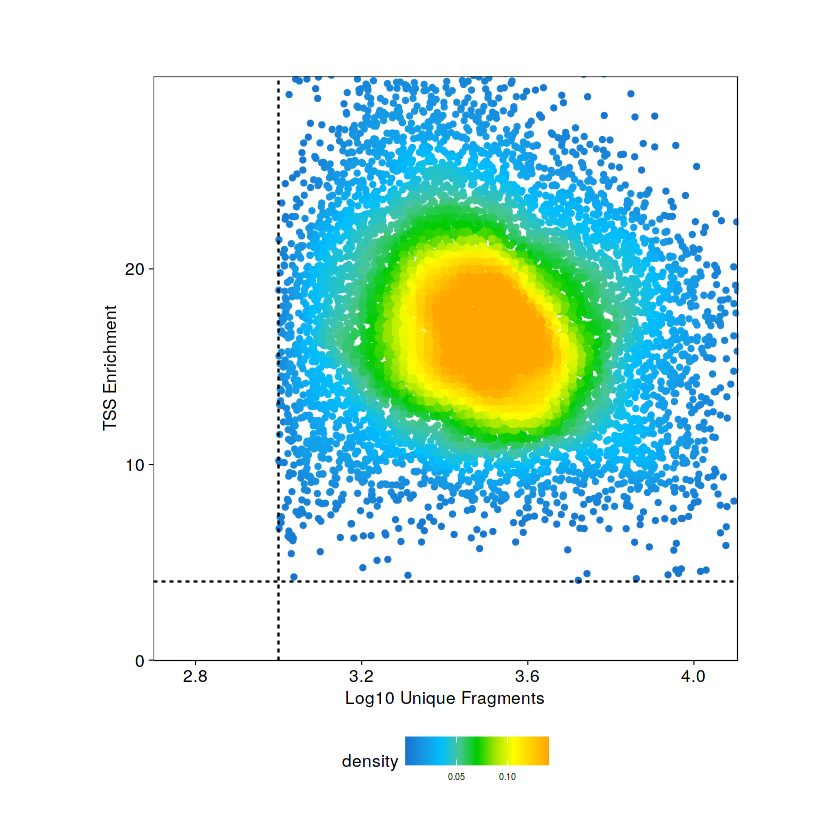

In [23]:
p <- ggPoint(
    x = df[,1], 
    y = df[,2], 
    colorDensity = TRUE,
    continuousSet = "sambaNight",
    xlabel = "Log10 Unique Fragments",
    ylabel = "TSS Enrichment",
    xlim = c(log10(500), quantile(df[,1], probs = 0.99)),
    ylim = c(0, quantile(df[,2], probs = 0.99))
) + geom_hline(yintercept = 4, lty = "dashed") + geom_vline(xintercept = 3, lty = "dashed")

p

To save an editable vectorized version of this plot, we use `plotPDF()`.

In [24]:
plotPDF(p, name = "TSS-vs-Frags.pdf", ArchRProj = projHeme1, addDOC = FALSE)


Plotting Ggplot!



### 3.3 Plotting Sample Statistics from an ArchRProject
When working with multiple distinct samples in a single integrated data set, it can be important to compare various metrics across all samples. ArchR provides two main plotting mechanisms for grouped data: ridge plots and violin plots. These are both accessed through the `plotGroups()` function. Of course, this plot type is not limited to sample-level data and can be used for plotting of downstream group-level information for groups such as clusters.

#### Example 1. Make a ridge plot for each sample for the TSS enrichment scores.
To make a ridge plot, we set `plotAs = "ridges"`.

In [25]:
p1 <- plotGroups(
    ArchRProj = projHeme1, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "ridges"
   )

1 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”




Picking joint bandwidth of 0.877



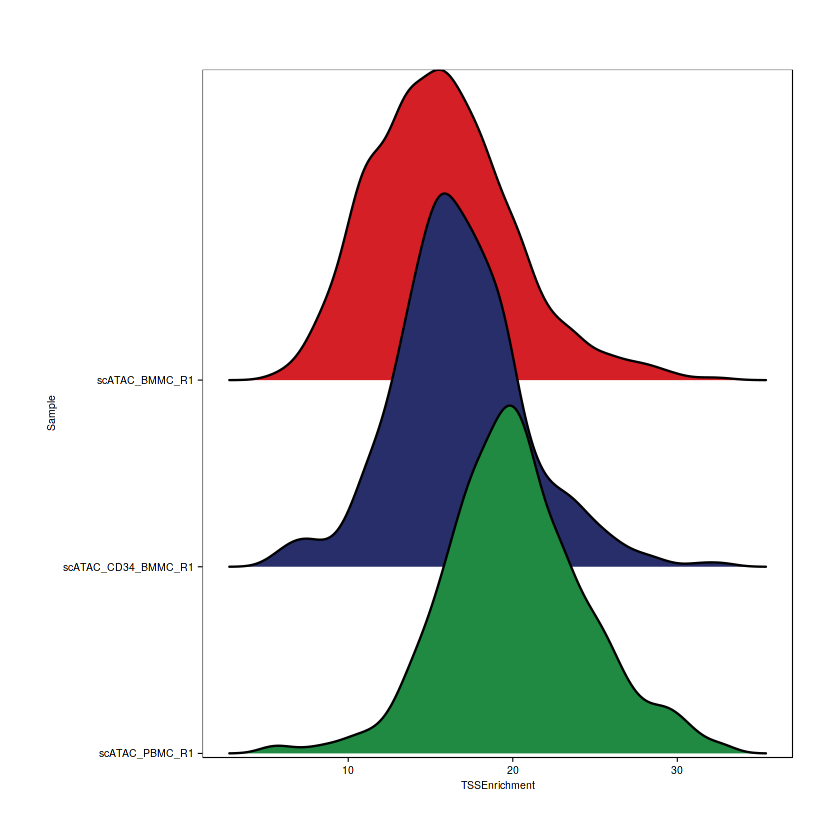

In [26]:
p1


#### Example 2. Make a violin plot for each sample for the TSS enrichment scores.
To make a violin plot, we set `plotAs = "violin"`. Violin plots in ArchR come with a box-and-whiskers plot in the style of Tukey as implemented by `ggplot2`. This means that the lower and upper hinges correspond to the 25th and 75th percentiles, respectively, and the middle corresponds to the median. The lower and upper whiskers extend from the hinge to the lowest or highest value or 1.5 times the interquartile range (the distance between the 25th and 75th percentiles).

In [27]:
p2 <- plotGroups(
    ArchRProj = projHeme1, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )

1 




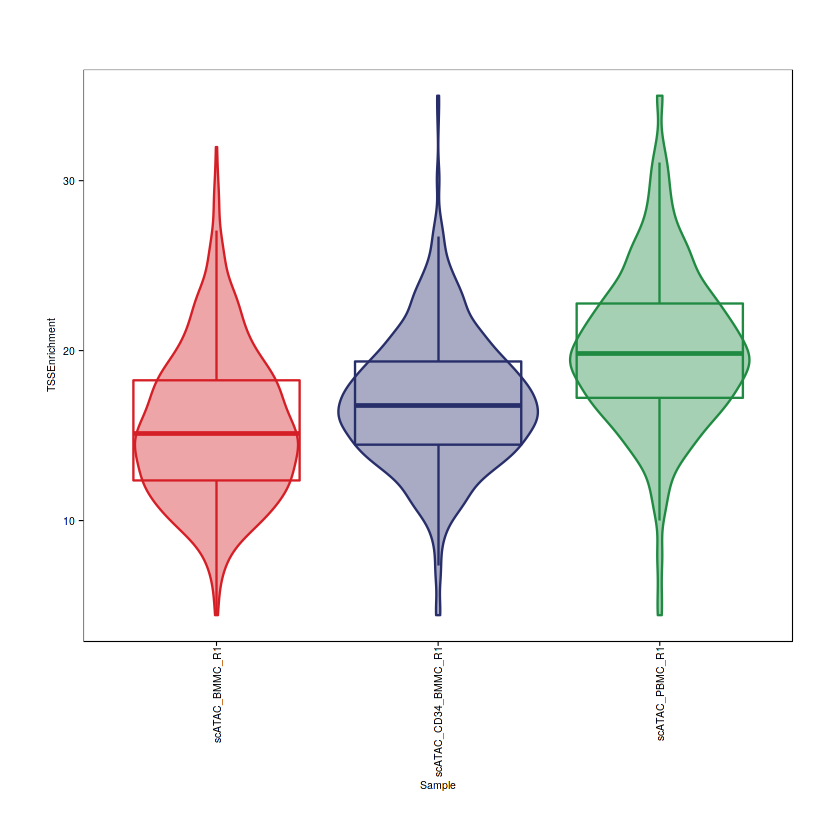

In [28]:
p2

#### Example 3. Make a ridge plot for each sample for the log10(unique nuclear fragments).

In [29]:
p3 <- plotGroups(
    ArchRProj = projHeme1, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "log10(nFrags)",
    plotAs = "ridges"
   )

1 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”




Picking joint bandwidth of 0.0502



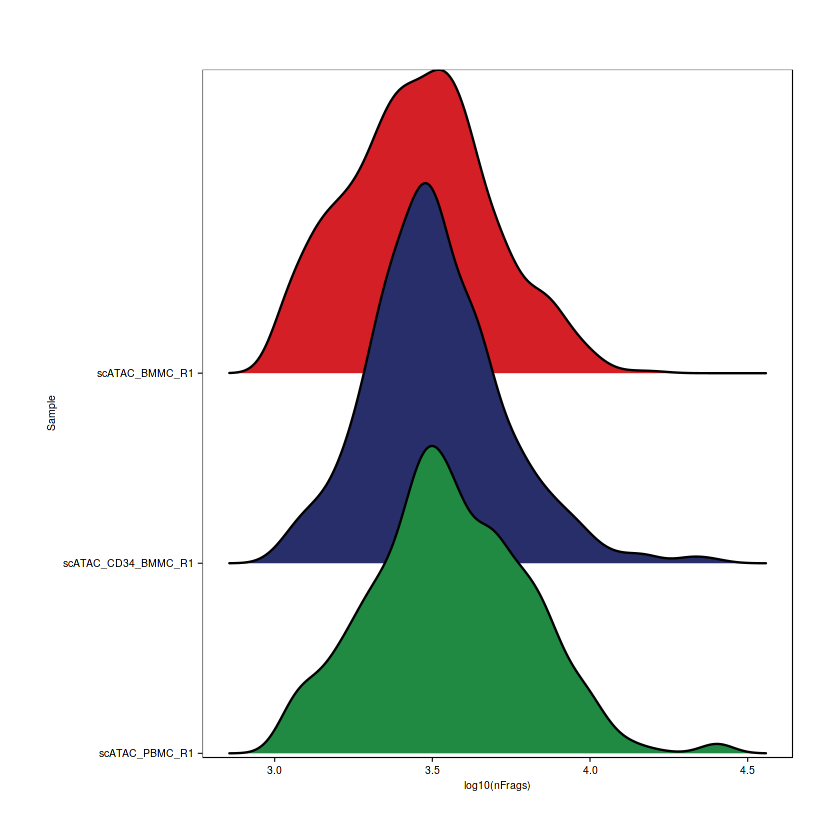

In [30]:
p3

#### Example 4. Make a violin plot for each sample for the log10(unique nuclear fragments).

In [31]:
p4 <- plotGroups(
    ArchRProj = projHeme1, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "log10(nFrags)",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )

1 




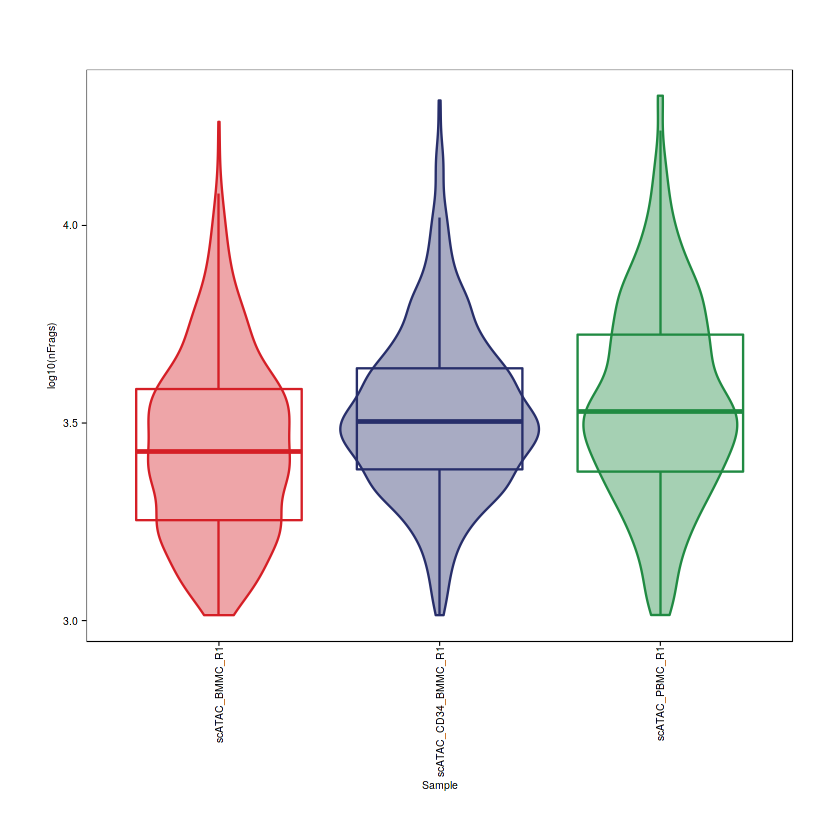

In [32]:
p4

To save editable vectorized versions of these plots, we use `plotPDF()`.

In [33]:
plotPDF(p1,p2,p3,p4, name = "QC-Sample-Statistics.pdf", ArchRProj = projHeme1, addDOC = FALSE, width = 4, height = 4)

Plotting Ggplot!

Picking joint bandwidth of 0.877

Picking joint bandwidth of 0.877

Plotting Ggplot!

Plotting Ggplot!

Picking joint bandwidth of 0.0502

Picking joint bandwidth of 0.0502

Plotting Ggplot!



### 3.4 Plotting Sample Fragment Size Distribution and TSS Enrichment Profiles.
Because of how the data is stored and accessed, ArchR can compute fragment size distributions and TSS enrichment profiles from Arrow files very quickly.

**Fragment size distributions**: To plot the fragment size distributions of all samples, we use the `plotFragmentSizes()` function. Fragment size distributions in ATAC-seq can be quite variable across samples, cell types, and batches. Slight differences like those shown below are common and do not necessarily correlate with differences in data quality.

ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-3211d3545ff-Date-2020-10-08_Time-13-20-06.log
If there is an issue, please report to github with logFile!

2020-10-08 13:20:06 : scATAC_BMMC_R1 Computing FragmentSizes (1 of 3)!, 0.003 mins elapsed.

2020-10-08 13:20:07 : scATAC_BMMC_R1 Finished Computing FragmentSizes (1 of 3)!, 0.032 mins elapsed.

2020-10-08 13:20:07 : scATAC_CD34_BMMC_R1 Computing FragmentSizes (2 of 3)!, 0.032 mins elapsed.

2020-10-08 13:20:10 : scATAC_CD34_BMMC_R1 Finished Computing FragmentSizes (2 of 3)!, 0.068 mins elapsed.

2020-10-08 13:20:10 : scATAC_PBMC_R1 Computing FragmentSizes (3 of 3)!, 0.068 mins elapsed.

2020-10-08 13:20:11 : scATAC_PBMC_R1 Finished Computing FragmentSizes (3 of 3)!, 0.089 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-3211d3545ff-Date-2020-10-08_Time-13-20-06.log



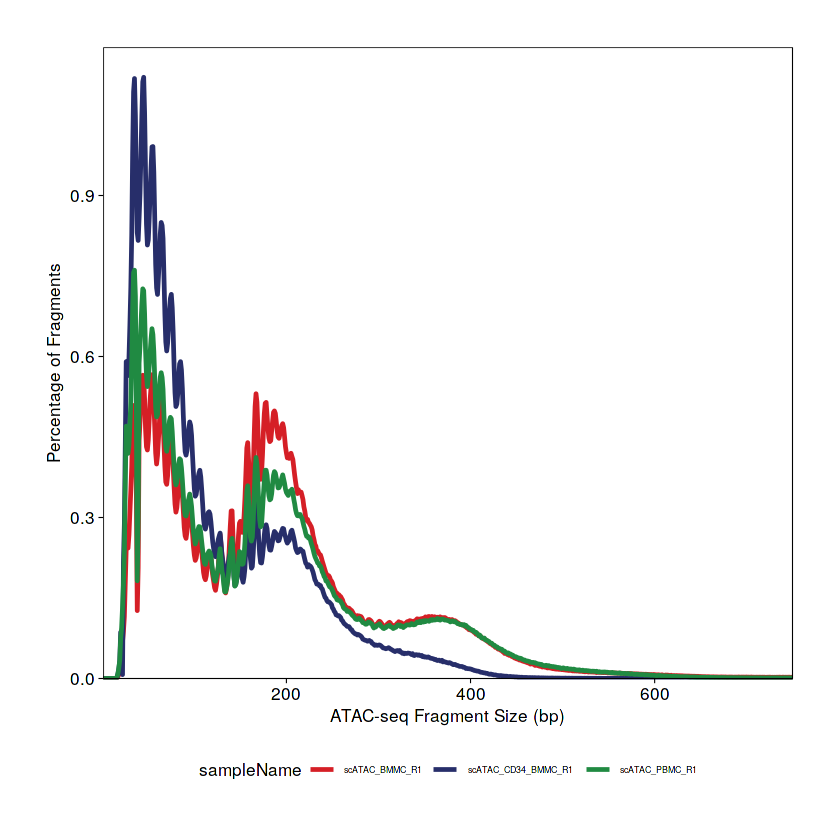

In [34]:
p1 <- plotFragmentSizes(ArchRProj = projHeme1)
p1

**TSS enrichment profiles**: To plot TSS enrichment profiles, we use the `plotTSSEnrichment()` function. TSS enrichment profiles should show a clear peak in the center and a smaller shoulder peak right-of-center which is caused by the well-positioned +1 nucleosome.

ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-32113e088739-Date-2020-10-08_Time-13-20-11.log
If there is an issue, please report to github with logFile!

2020-10-08 13:20:11 : scATAC_BMMC_R1 Computing TSS (1 of 3)!, 0.004 mins elapsed.

2020-10-08 13:20:22 : scATAC_BMMC_R1 Finished Computing TSS (1 of 3)!, 0.184 mins elapsed.

2020-10-08 13:20:22 : scATAC_CD34_BMMC_R1 Computing TSS (2 of 3)!, 0.184 mins elapsed.

2020-10-08 13:20:30 : scATAC_CD34_BMMC_R1 Finished Computing TSS (2 of 3)!, 0.321 mins elapsed.

2020-10-08 13:20:30 : scATAC_PBMC_R1 Computing TSS (3 of 3)!, 0.321 mins elapsed.

2020-10-08 13:20:38 : scATAC_PBMC_R1 Finished Computing TSS (3 of 3)!, 0.449 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotTSSEnrichment-32113e088739-Date-2020-10-08_Time-13-20-11.log



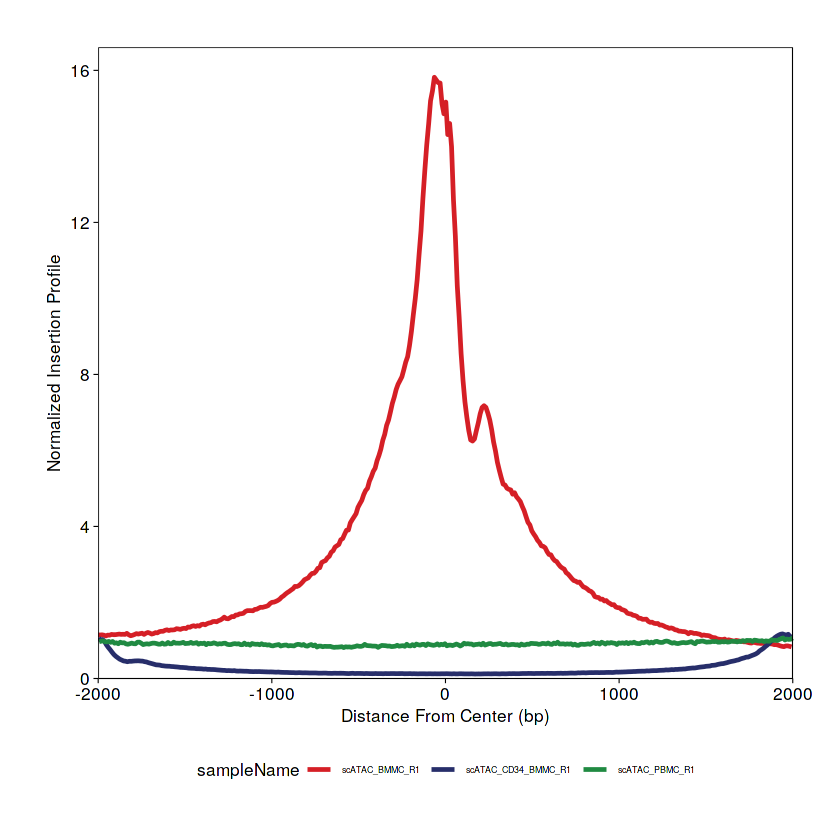

In [35]:
p2 <- plotTSSEnrichment(ArchRProj = projHeme1)
p2

To save editable vectorized versions of these plots, we use `plotPDF()`.

In [36]:
plotPDF(p1,p2, name = "QC-Sample-FragSizes-TSSProfile.pdf", ArchRProj = projHeme1, addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!

Plotting Ggplot!



### Saving and loading an `ArchRProject`
ArchR provides a facile way to save an `ArchRProject` object to either re-load at a later time or share with other users. Fundamentally, an `ArchRProject` points to a set of Arrow files. Because of this, the process of saving an `ArchRProject` using the `saveArchRProject()` function will:

1. Copy the current Arrow files to the designated `outputDirectory` so that they are exclusively associated with the new `ArchRProject` object.

2. Save a copy of the designated ArchRProject in the outputDirectory.

For example, we can save our `projHeme1` using `saveArchRProject()` which will allow us to use this project in future chapters.

In [37]:
saveArchRProject(ArchRProj = projHeme1, outputDirectory = "Save-ProjHeme1", load = FALSE)

Copying ArchRProject to new outputDirectory : /home/james/Documents/Leuven/year-two/Integrated-Bioinformatics-Project/ArchR/Archr-tutorial/Save-ProjHeme1

Copying Arrow Files...

Copying Arrow Files (1 of 3)

Copying Arrow Files (2 of 3)

Copying Arrow Files (3 of 3)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 1): Plots

Saving ArchRProject...



This will copy the Arrow files and save a .RDS file of the `projHeme1` `ArchRProject` object in the specified `outputDirectory`. Very important! This process does NOT automatically update the `ArchRProject` object that is active in your current R session. Specifically, the object named `projHeme1` in the current R session will still point to the original location of the Arrow files, not the copied Arrow files that reside in the specified `outputDirectory`. If we wanted to do this, we would specify `load = TRUE` which causes the `saveArchRProject()` function to return the saved `ArchRProject` object which you can assign to overwrite the original `ArchRProject` object using `<-`. This effectively saves and loads the `ArchRProject` from its new location.

### 3.6 Filtering Doublets from an ArchRProject
After we have added information on the predicted doublets using `addDoubletScores()`, we can remove these predicted doublets using `filterDoublets()`. One of the key elements of this filtering step is the `filterRatio` which is the maximum ratio of predicted doublets to filter based on the number of pass-filter cells. For example, if there are 5000 cells, the maximum number of filtered predicted doublets would be `filterRatio * 5000^2 / (100000)` (which simplifies to `filterRatio * 5000 * 0.05`). This `filterRatio` allows you to apply a consistent filter across multiple different samples that may have different percentages of doublets because they were run with different cell loading concentrations. The higher the `filterRatio`, the greater the number of cells potentially removed as doublets.

First, we filter the doublets. We save this as a new `ArchRProject` for the purposes of this stepwise tutorial but you can always overwrite your original `ArchRProject` object.

In [38]:
createLogFile(name = "posix-error-logfile", logDir = "ArchRLogs", useLogs = getArchRLogging())

[1] "ArchRLogs/ArchR-posix-error-logfile-321174e4528b-Date-2020-10-08_Time-13-20-41.log"

In [39]:
projHeme2 <- filterDoublets(projHeme1)

Filtering 410 cells from ArchRProject!

	scATAC_BMMC_R1 : 243 of 4932 (4.9%)

	scATAC_CD34_BMMC_R1 : 107 of 3275 (3.3%)

	scATAC_PBMC_R1 : 60 of 2454 (2.4%)



ERROR: Error in as.POSIXct.numeric(e): 'origin' must be supplied


In [ ]:

createLogFile(name = "posix-error-logfile-2", logDir = "ArchRLogs", useLogs = getArchRLogging())

Previously, we saw that `projHeme1` had 10,661 cells. Now, we see that `projHeme2` has 10,251 cells, indicating that 410 cells (3.85%) were removed by doublet filtration as indicated above.

In [ ]:
projHeme2

If you wanted to filter more cells from the ArchR Project, you would use a higher `filterRatio`. To see additional arguments that can be tweaked, try `?filterDoublets`.

In [ ]:
projHemeTmp <- filterDoublets(projHeme1, filterRatio = 1.5)

In [ ]:
rm(projHemeTmp)

In [ ]:
sessionInfo()